In [157]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor, plot_importance


# Data overview

In [90]:
# 1. Data Overview
""" Which columns are in the dataset? 
What are their data types and shapes? 
Are there any missing values?"""

""" Answer:
What columns do you see?
Are there missing values?
How many stores and departments are there?"""

# Load the data
train_df = pd.read_csv("train.csv")
stores_df = pd.read_csv("Store.csv")
features_df = pd.read_csv("features.csv")

# Check the first few rows
print(f"\n{train_df.head()}")
print(f"\n{stores_df.head()}")
print(f"\n{features_df.head()}")


   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  05/02/2010      24924.50      False
1      1     1  12/02/2010      46039.49       True
2      1     1  19/02/2010      41595.55      False
3      1     1  26/02/2010      19403.54      False
4      1     1  05/03/2010      21827.90      False

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358      

In [3]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [4]:
train_df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,28/09/2012,508.37,False
421566,45,98,05/10/2012,628.10,False
421567,45,98,12/10/2012,1061.02,False
421568,45,98,19/10/2012,760.01,False
421569,45,98,26/10/2012,1076.80,False


In [5]:
print("\nTrain Data Info:")
train_df.info()

print("\nFeatures Data Info:")
features_df.info()

print("\nStores Data Info:")
stores_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB

Features Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3

In [6]:
# Check shape and data types
print(f"\nDataset Shape: {train_df.shape}")


Dataset Shape: (421570, 5)


In [7]:
features_df.shape[0]

8190

In [8]:
# Check for missing values
print(f"\nMissing Values: \n{train_df.isnull().sum()} ")
print(f"\nMissing Values: \n{stores_df.isnull().sum()} ")
print(f"\nMissing Values: \n{features_df.isnull().sum()} ")


Missing Values: 
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64 

Missing Values: 
Store    0
Type     0
Size     0
dtype: int64 

Missing Values: 
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64 


In [9]:
# Check for number of stores & dept. in each store
print(f"\nNumber of stores: \n{train_df['Store'].nunique()}")
print(f"\nNumber of departments : \n{train_df['Dept'].nunique()}")
print(f"\nDepartment in each store : \n{train_df.groupby('Store')['Dept'].nunique()}")


Number of stores: 
45

Number of departments : 
81

Department in each store : 
Store
1     77
2     78
3     72
4     78
5     72
6     77
7     76
8     76
9     73
10    77
11    78
12    75
13    79
14    77
15    79
16    76
17    76
18    78
19    79
20    78
21    77
22    76
23    77
24    77
25    77
26    76
27    78
28    77
29    77
30    64
31    76
32    77
33    63
34    78
35    74
36    63
37    62
38    63
39    75
40    77
41    77
42    62
43    61
44    62
45    74
Name: Dept, dtype: int64


In [119]:
full_df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,week,month,year
count,282110.000000,282110.000000,282110.000000,282110.000000,282110.000000,282110.000000,282110.000000,282110.000000,282110.000000,282110.000000,282110.000000,282110.000000,282110.00000,282110.000000,282110.000000,282110.000000
mean,22.198093,44.228815,15902.713371,136709.191638,59.937065,3.380279,2594.245918,1244.600750,650.598868,1065.053424,1604.528493,171.383740,7.94013,25.921839,6.326614,2011.013548
std,12.788102,30.504665,22723.941441,60998.033630,18.212094,0.448686,6215.727311,6128.313496,6710.091479,4229.523084,3911.840595,39.208432,1.86047,14.549890,3.319972,0.796751
min,1.000000,1.000000,0.010000,34875.000000,5.540000,2.472000,0.000000,-265.760000,-1.000000,0.000000,0.000000,126.064000,3.87900,1.000000,1.000000,2010.000000
25%,11.000000,18.000000,2097.727500,93638.000000,47.100000,2.971000,0.000000,0.000000,0.000000,0.000000,0.000000,132.064433,6.88500,13.000000,3.000000,2010.000000
50%,22.000000,37.000000,7581.540000,140167.000000,61.880000,3.486000,0.000000,0.000000,0.000000,0.000000,0.000000,182.441538,7.85600,26.000000,6.000000,2011.000000
75%,33.000000,74.000000,20068.255000,202505.000000,73.880000,3.747000,3062.020000,26.800000,4.590000,435.990000,2282.230000,212.845337,8.56700,38.000000,9.000000,2012.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.449000,88646.760000,104519.540000,141630.610000,67474.850000,105223.110000,227.232807,14.31300,52.000000,12.000000,2012.000000


# Cleaning and preprocessing

In [120]:
fillnan = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
full_df[fillnan] = full_df[fillnan].fillna(0)

In [122]:
full_df.isnull().sum()

Store            0
Dept             0
Date             0
Weekly_Sales     0
IsHoliday        0
Type             0
Size             0
Size_Category    0
Temperature      0
Fuel_Price       0
MarkDown1        0
MarkDown2        0
MarkDown3        0
MarkDown4        0
MarkDown5        0
CPI              0
Unemployment     0
Super_Bowl       0
Labor_Day        0
Thanksgiving     0
Christmas        0
week             0
month            0
year             0
dtype: int64

In [124]:
# Just keep track of the issue without modifying the dataset
print("Number of suspicious Weekly_Sales values:", (full_df['Weekly_Sales'] == 0.01).value_counts())

Number of suspicious Weekly_Sales values: False    282090
True         20
Name: Weekly_Sales, dtype: int64


In [125]:
suspicious_sales = full_df[full_df['Weekly_Sales'] == 0.01]
print(suspicious_sales)

        Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
6210        1    99 2012-07-20          0.01      False    A  151315   
52701       8    99 2012-10-26          0.01      False    A  155078   
65944      11    99 2010-04-16          0.01      False    A  207499   
72114      11    99 2012-09-28          0.01      False    A  207499   
118665     19    99 2010-02-19          0.01      False    A  203819   
128146     20    99 2011-04-15          0.01      False    A  203742   
143962     22    18 2012-05-18          0.01      False    B  119557   
153446     24    99 2010-10-22          0.01      False    A  203819   
157944     24    99 2012-07-13          0.01      False    A  203819   
194955     30    99 2011-12-23          0.01      False    C   42988   
199949     31    99 2011-07-15          0.01      False    A  203750   
200655     31    99 2011-10-21          0.01      False    A  203750   
200725     31    99 2011-10-28          0.01      False    A  20

In [127]:
print(suspicious_sales['Store'].value_counts())  # Check which stores have the issue
print(suspicious_sales['Dept'].value_counts())   # Check which departments are affected
print(suspicious_sales['Date'].value_counts())   # See if it happens on specific dates

# If the issue is limited to a few stores or departments, it might indicate a data collection or reporting problem.

31    6
11    2
24    2
39    2
1     1
8     1
19    1
20    1
22    1
30    1
33    1
34    1
Name: Store, dtype: int64
99    19
18     1
Name: Dept, dtype: int64
2012-05-18    2
2012-07-20    1
2011-07-15    1
2010-03-26    1
2012-07-27    1
2012-09-14    1
2012-05-25    1
2012-02-24    1
2011-10-28    1
2011-10-21    1
2011-12-23    1
2012-10-26    1
2012-07-13    1
2010-10-22    1
2011-04-15    1
2010-02-19    1
2012-09-28    1
2010-04-16    1
2010-04-23    1
Name: Date, dtype: int64


In [129]:
# replace them with The median sales of the same store and department
full_df.loc[full_df['Weekly_Sales'] == 0.01, 'Weekly_Sales'] = full_df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform('median')

In [130]:
print("Number of suspicious Weekly_Sales values:", (full_df['Weekly_Sales'] == 0.01).value_counts())

Number of suspicious Weekly_Sales values: False    282110
Name: Weekly_Sales, dtype: int64


In [128]:
# Merge train and stores data
merged_df = pd.merge(train_df, stores_df, on='Store')

store_dept_table = pd.pivot_table(merged_df, index='Store', columns='Dept',values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


In [11]:
""""it is obviously seen that there are some wrong values such as there are 0 and minus values for weekly sales. 
But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week.
So, change this values."""

merged_df.loc[merged_df['Weekly_Sales']<=0]

"""1358 rows in 421570 rows means 0.3%, 
so I can delete and ignore these rows which contains wrong sales values."""

merged_df = merged_df.loc[merged_df['Weekly_Sales'] > 0]

merged_df.shape 

(420212, 7)

In [12]:
train_df['Date'] = pd.to_datetime(train_df['Date'] , dayfirst=True)

# Date & Weekly_sales

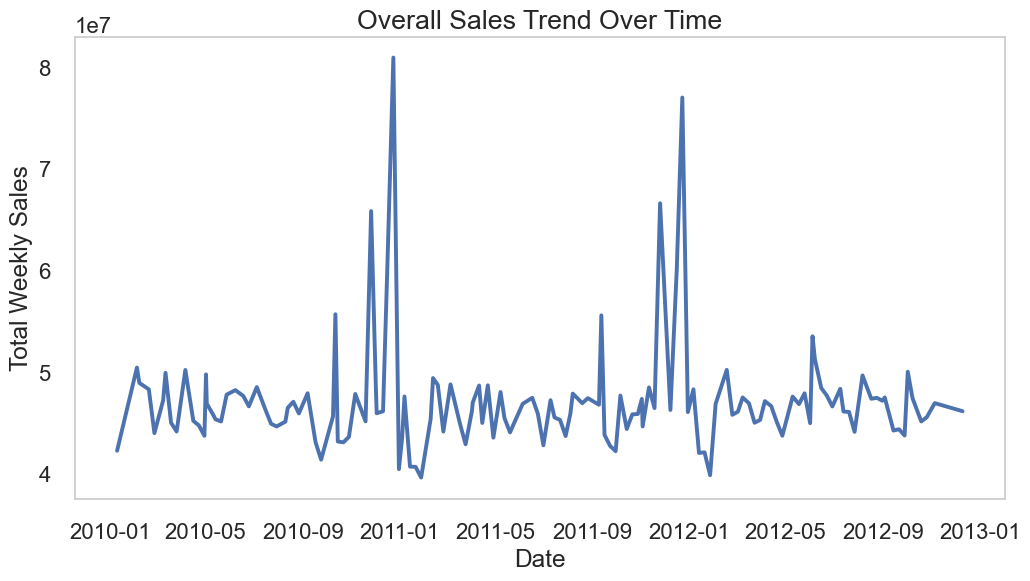

'Answer:\nDo you notice any trends or seasonality?\nAre there sharp peaks (holiday seasons)?'

In [131]:
#Date & Weekly Sales

# 2. Sales Trends & Distributions
"""What are the overall sales trends over time? 
How do sales vary across stores?"""

# Convert date to datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Group sales by date
sales_trend = train_df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Plot sales over time
plt.figure(figsize=(12, 6))
plt.plot(sales_trend['Date'], sales_trend['Weekly_Sales'])
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Overall Sales Trend Over Time')
plt.grid()
plt.show()

"""Answer:
Do you notice any trends or seasonality?
Are there sharp peaks (holiday seasons)?"""

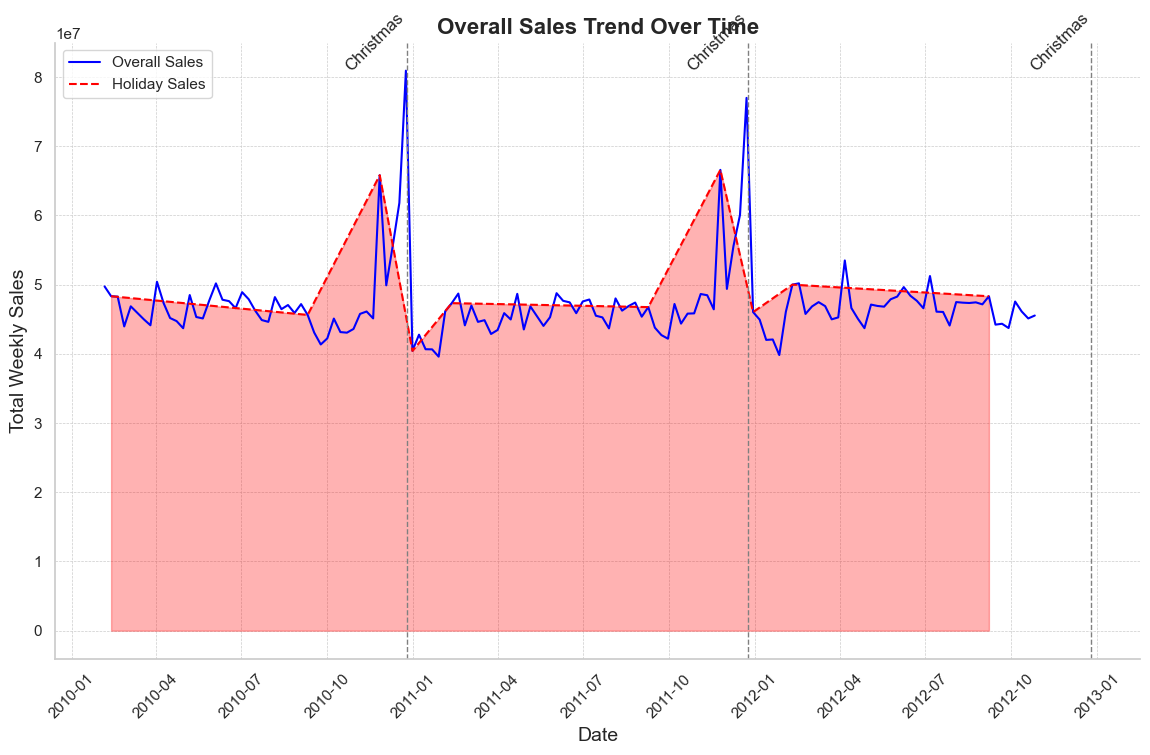

In [14]:
# Convert date to datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Group sales by date
sales_trend = train_df.groupby('Date')['Weekly_Sales'].sum().reset_index()
holiday_sales_trend = train_df[train_df['IsHoliday']].groupby('Date')['Weekly_Sales'].sum().reset_index()


# Plot sales over time
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8), dpi=100)
plt.plot(sales_trend['Date'], sales_trend['Weekly_Sales'], label='Overall Sales', color='blue')
plt.plot(holiday_sales_trend['Date'], holiday_sales_trend['Weekly_Sales'], color='red', label='Holiday Sales', linestyle='--')
plt.fill_between(holiday_sales_trend['Date'], 0, holiday_sales_trend['Weekly_Sales'], color='red', alpha=0.3)

# Title and labels
plt.title('Overall Sales Trend Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Weekly Sales', fontsize=14)

# Grid and spines
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.legend()

# Add annotations for major holidays 
major_holidays = ['2010-12-25', '2011-12-25', '2012-12-25']
for holiday in major_holidays:
    plt.axvline(pd.to_datetime(holiday), color='grey', linestyle='--', linewidth=1)
    plt.text(pd.to_datetime(holiday), max(sales_trend['Weekly_Sales']), 'Christmas', rotation=45, fontsize=12, ha='right')


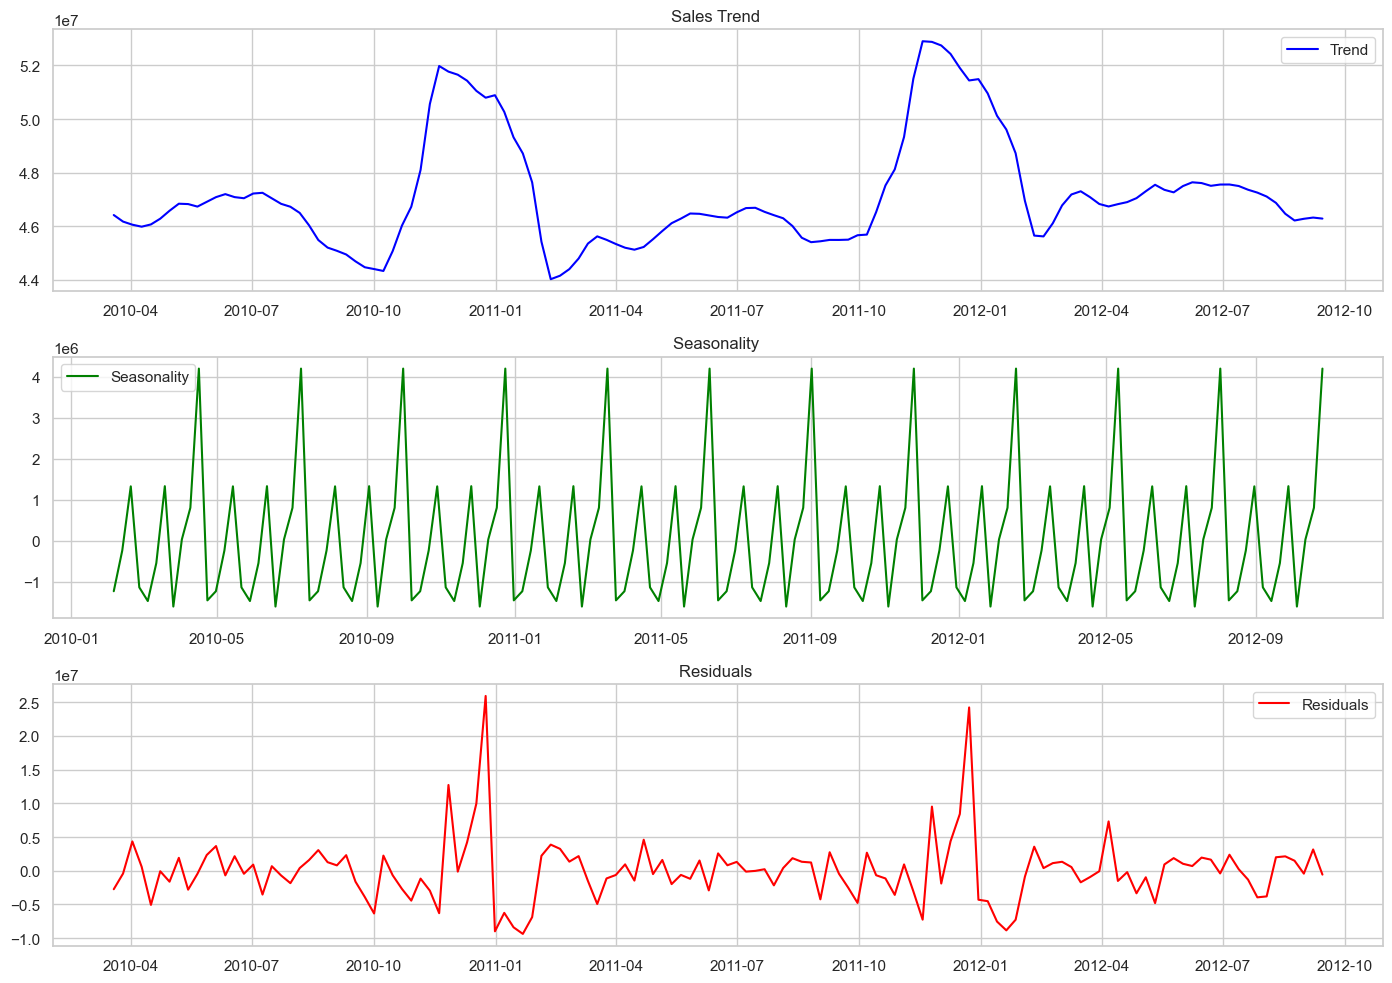

In [15]:
# Group sales by date and ensure the index is in datetime format
sales_trend = train_df.groupby('Date')['Weekly_Sales'].sum()
sales_trend.index = pd.to_datetime(sales_trend.index)

# Time series decomposition
decomposition = seasonal_decompose(sales_trend, model="additive", period=12)  
# Plot the three components: Trend, Seasonality, and Residuals
plt.figure(figsize=(14, 10))

# Sales trend
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label="Trend", color="blue")
plt.title("Sales Trend ")
plt.legend()

# Seasonality
plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label="Seasonality", color="green")
plt.title("Seasonality ")
plt.legend()

# Residuals
plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label="Residuals", color="red")
plt.title("Residuals ")
plt.legend()

plt.tight_layout()
plt.show()

# weekly sales of Stores 

Top 5 Stores by Total Sales:
     Store  Weekly_Sales
19     20  3.014014e+08
3       4  2.995453e+08
13     14  2.890019e+08
12     13  2.865180e+08
1       2  2.753872e+08


' Answer:\nWhich stores perform the best?\nDoes store size influence sales?'

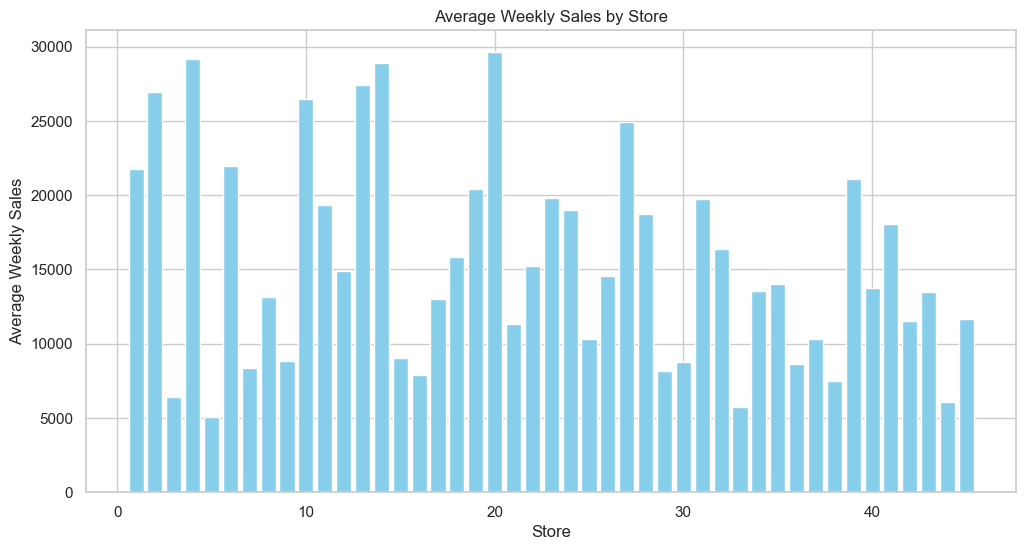

In [16]:
#  3. Store-Level Analysis
"""How do sales differ across stores? 
Are larger stores making more sales?"""

# Calculate average sales per store
store_sales = merged_df.groupby('Store')['Weekly_Sales'].mean().reset_index()

# Calculate Average sales of store according to store size
Store_size_sales = merged_df.groupby('Size')['Weekly_Sales'].mean().reset_index()

# Sort and visualize
store_sales = store_sales.sort_values(by='Weekly_Sales', ascending=False)
Store_size_sales = Store_size_sales.sort_values(by='Weekly_Sales', ascending=True)


plt.figure(figsize=(12, 6))
plt.bar(store_sales['Store'], store_sales['Weekly_Sales'], color='skyblue')
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Store')

# Store-wise sales
store_sales = merged_df.groupby("Store")["Weekly_Sales"].sum().reset_index().sort_values("Weekly_Sales", ascending=False)
print("Top 5 Stores by Total Sales:\n", store_sales.head())

""" Answer:
Which stores perform the best?
Does store size influence sales?"""

In [17]:
max(merged_df['Size'])

219622

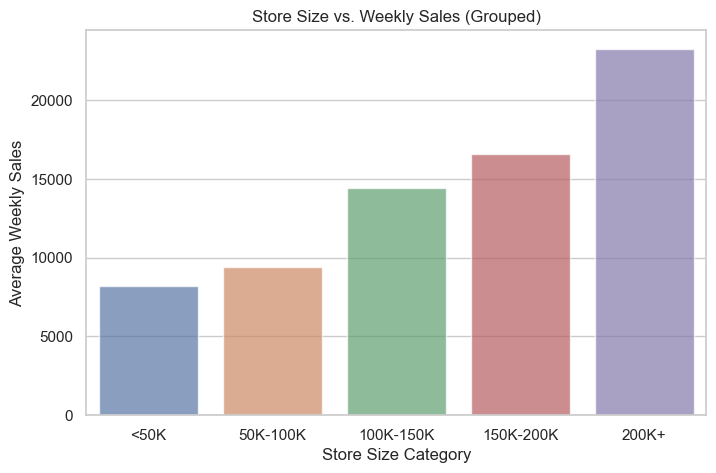

In [18]:
# Define bins and labels
bins = [0, 50000, 100000, 150000, 200000, 250000]  
labels = ["<50K", "50K-100K", "100K-150K", "150K-200K", "200K+"]

# Create a new column with bin categories
merged_df["Size_Category"] = pd.cut(merged_df["Size"], bins=bins, labels=labels)

# Aggregate sales by size category
size_sales = merged_df.groupby("Size_Category")["Weekly_Sales"].mean().reset_index()

# Plot the results
plt.figure(figsize=(8, 5))
sns.barplot(x="Size_Category", y="Weekly_Sales", data=size_sales, alpha=0.7)
plt.title("Store Size vs. Weekly Sales (Grouped)")
plt.xlabel("Store Size Category")
plt.ylabel("Average Weekly Sales")
plt.show()


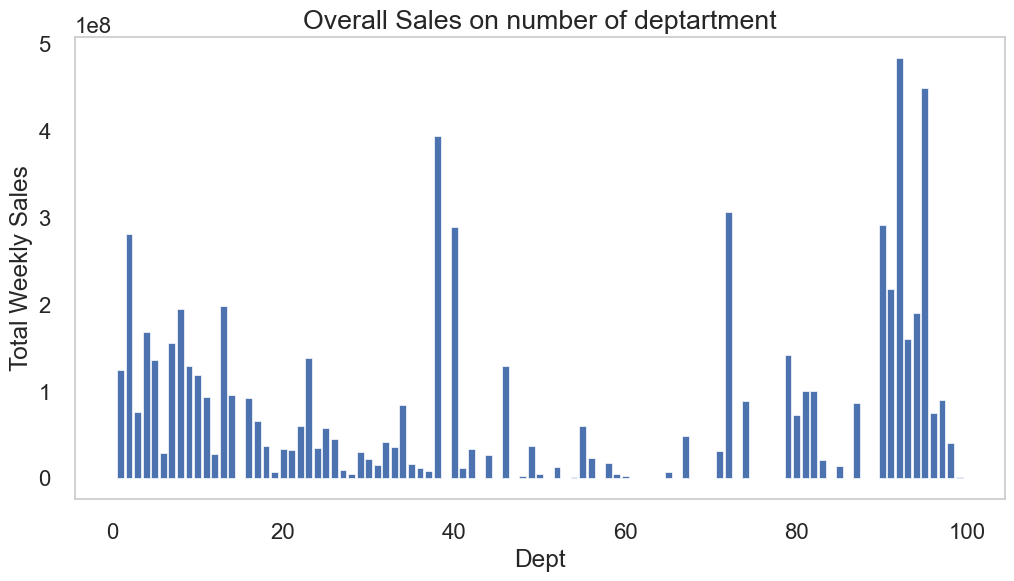

In [133]:
# Store department vs. sales
sales_dept = train_df.groupby('Dept')['Weekly_Sales'].sum().reset_index()

# Plot sales over time
plt.figure(figsize=(12, 6))
plt.bar(sales_dept['Dept'], sales_dept['Weekly_Sales'])
plt.xlabel('Dept')
plt.ylabel('Total Weekly Sales')
plt.title('Overall Sales on number of deptartment')
plt.grid()
plt.show()

# Features & Weekly_sales

In [24]:
# Merge train and features data
features_df['Date'] = pd.to_datetime(features_df['Date'])
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
full_df = pd.merge(merged_df, features_df, on=['Store', 'Date'])

full_df.drop(columns=["IsHoliday_y"], inplace=True)
full_df.rename(columns={"IsHoliday_x": "IsHoliday"}, inplace=True)
print(full_df)

        Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
0           1     1 2010-02-19      41595.55      False    A  151315   
1           1     2 2010-02-19      47928.89      False    A  151315   
2           1     3 2010-02-19      11523.47      False    A  151315   
3           1     4 2010-02-19      36826.95      False    A  151315   
4           1     5 2010-02-19      26468.27      False    A  151315   
...       ...   ...        ...           ...        ...  ...     ...   
282105     45    93 2012-10-26       2487.80      False    B  118221   
282106     45    94 2012-10-26       5203.31      False    B  118221   
282107     45    95 2012-10-26      56017.47      False    B  118221   
282108     45    97 2012-10-26       6817.48      False    B  118221   
282109     45    98 2012-10-26       1076.80      False    B  118221   

       Size_Category  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0          150K-200K        39.93       2.514        NaN        

              Weekly_Sales  Temperature  Fuel_Price  Unemployment  MarkDown1  \
Weekly_Sales      1.000000    -0.008916   -0.003745     -0.027885   0.075020   
Temperature      -0.008916     1.000000    0.155546      0.097205  -0.109741   
Fuel_Price       -0.003745     0.155546    1.000000     -0.025453   0.059489   
Unemployment     -0.027885     0.097205   -0.025453      1.000000   0.053154   
MarkDown1         0.075020    -0.109741    0.059489      0.053154   1.000000   
MarkDown2         0.036069    -0.340967   -0.245057      0.022445   0.046754   
MarkDown3         0.069286    -0.097824   -0.106806      0.014200  -0.115295   
MarkDown4         0.035255    -0.097207   -0.025199      0.027480   0.847503   
MarkDown5         0.081255     0.067752   -0.079168     -0.017728   0.210344   

              MarkDown2  MarkDown3  MarkDown4  MarkDown5  
Weekly_Sales   0.036069   0.069286   0.035255   0.081255  
Temperature   -0.340967  -0.097824  -0.097207   0.067752  
Fuel_Price    -0.24505

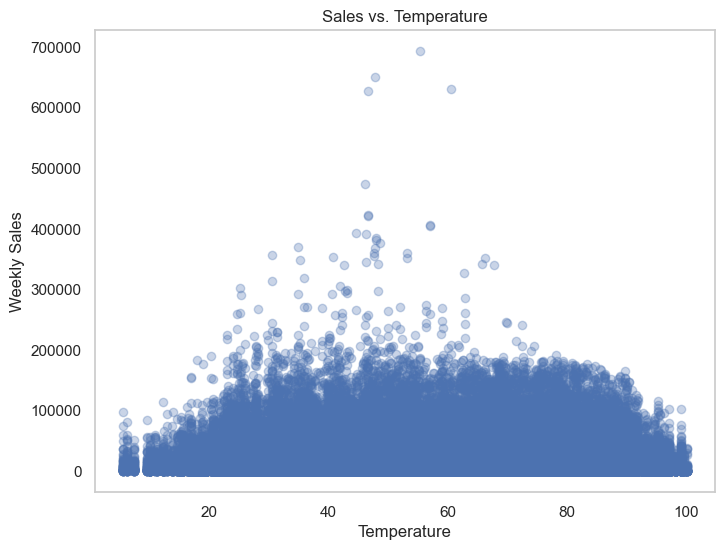

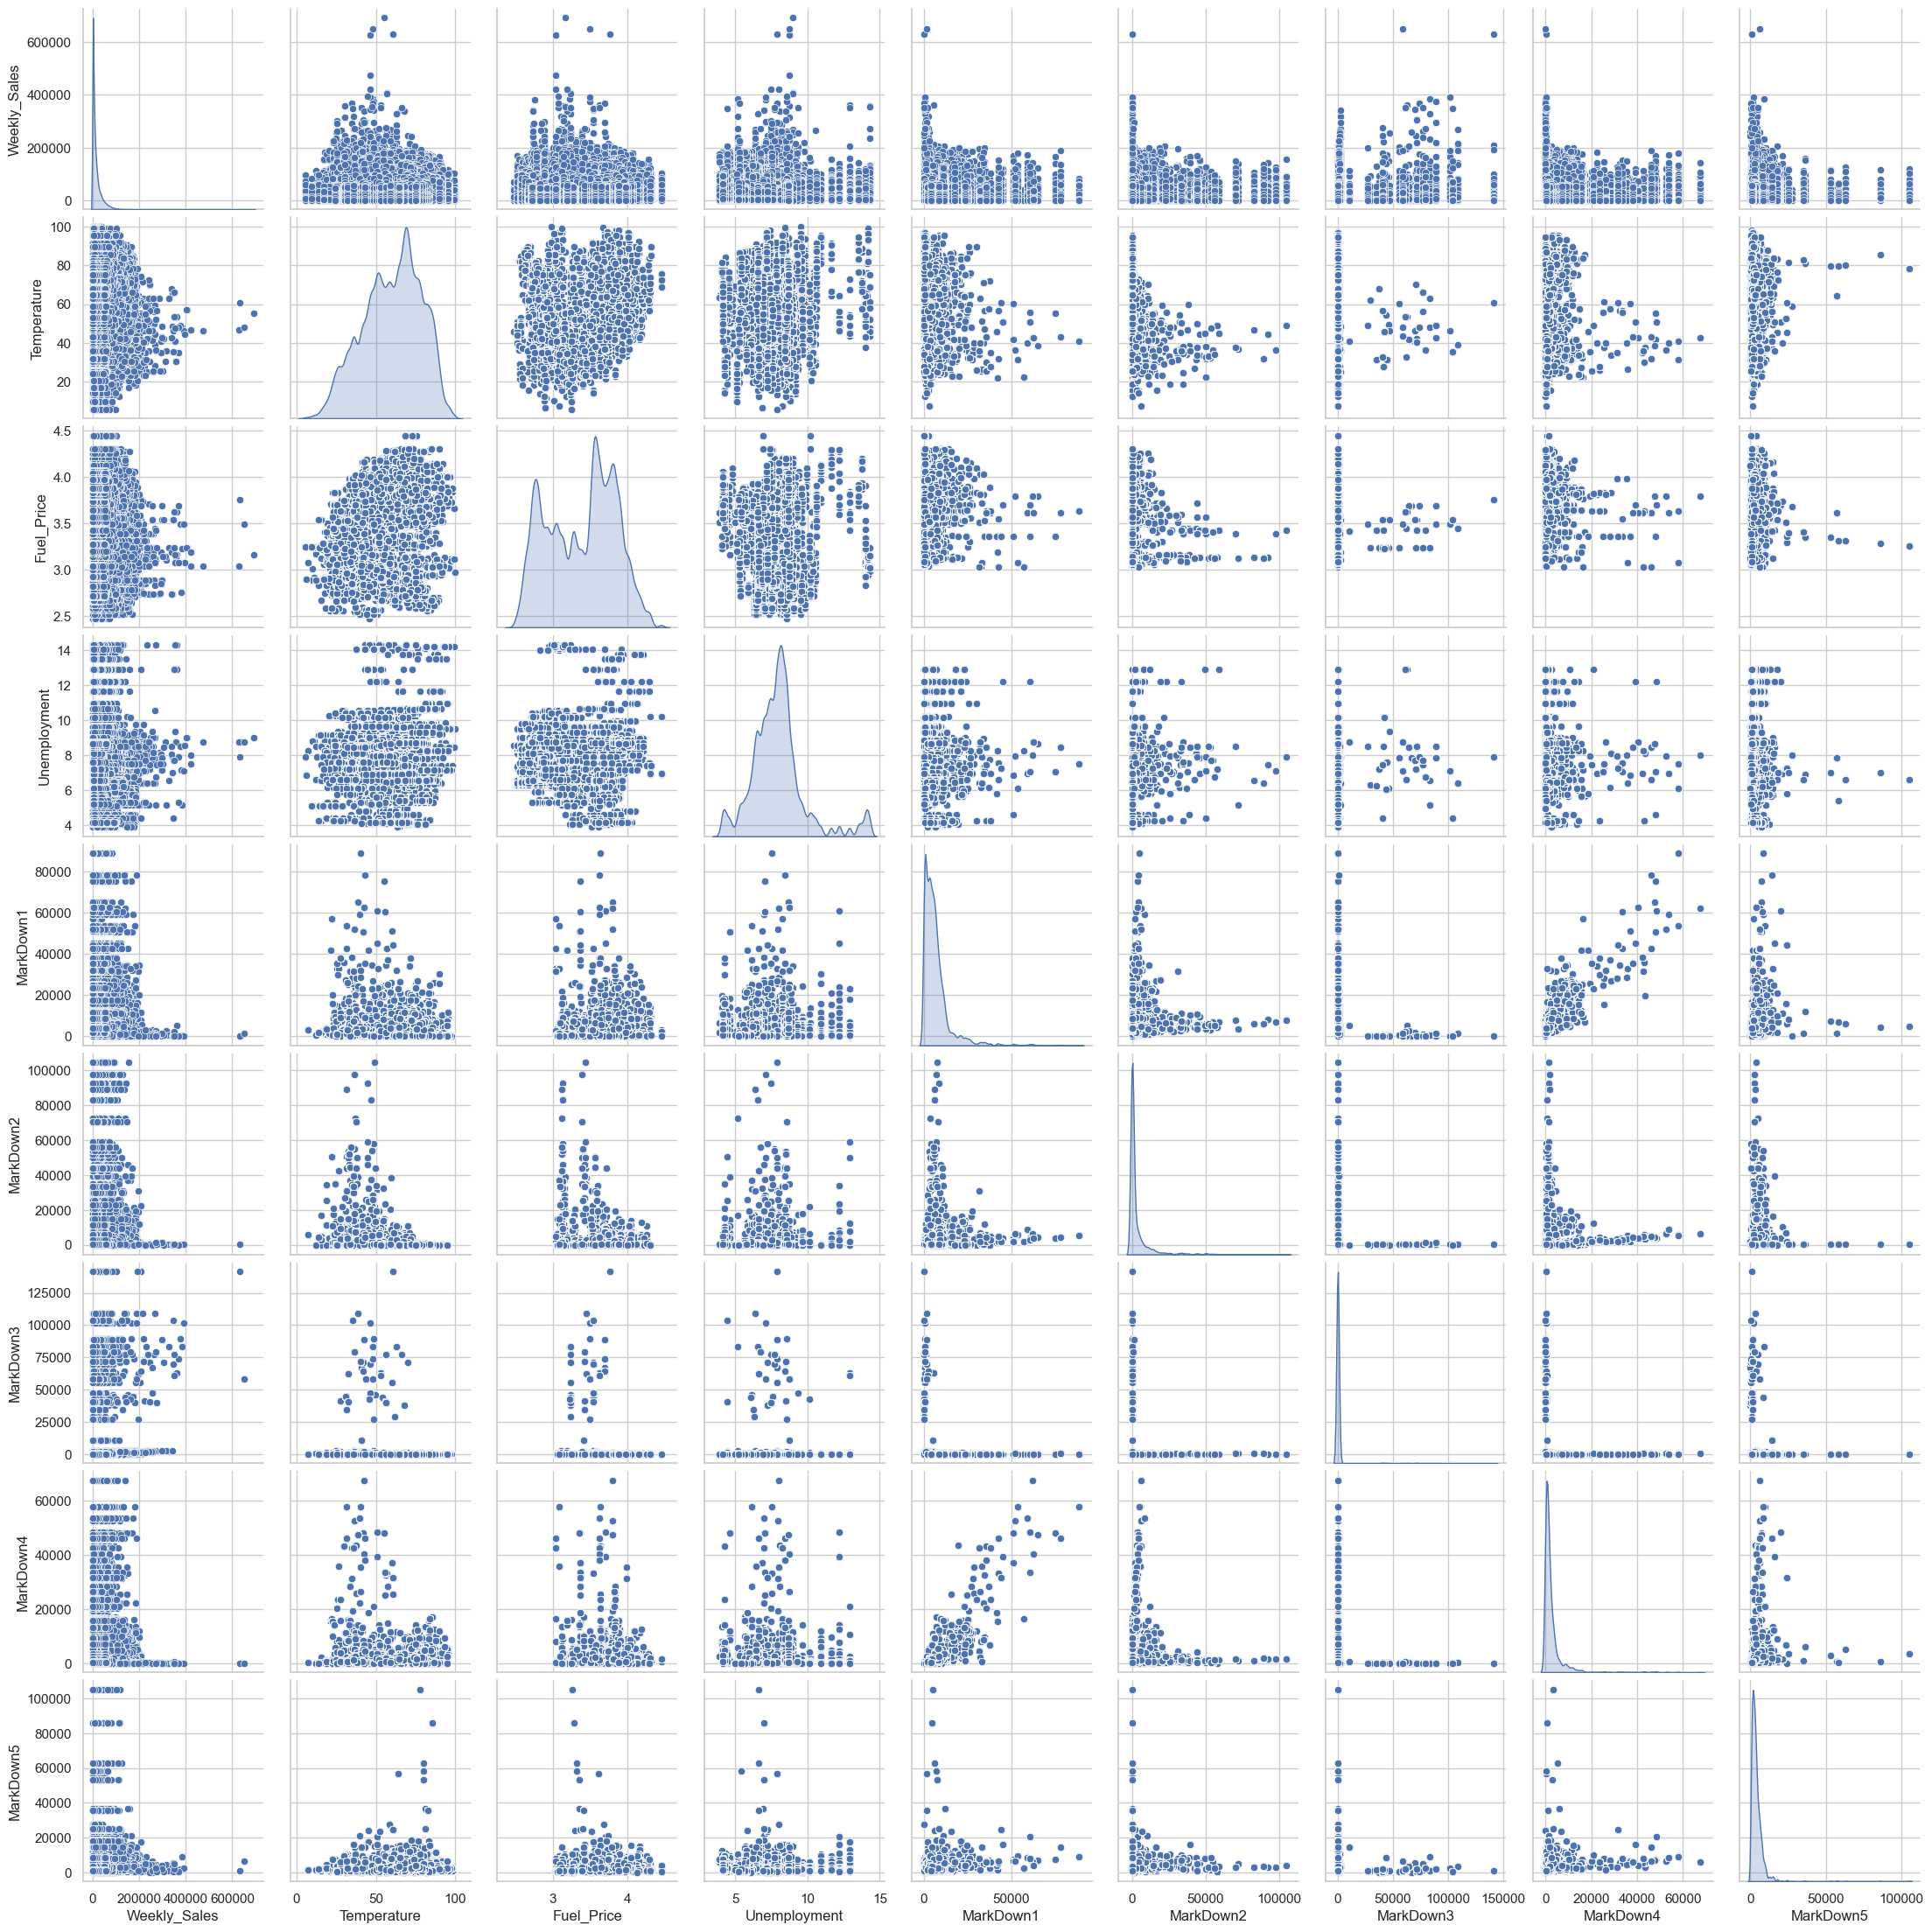

'Answer:\n\nIs there any correlation between sales and external factors?\nHow does seasonality impact sales?'

In [25]:
#   4. Feature Impact on Sales
"""How do features like temperature, fuel price, and holidays affect sales?"""

# Check correlations
correlation = full_df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'Unemployment','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5' ]].corr()
print(correlation)

# Scatter plot for sales vs. temperature
plt.figure(figsize=(8, 6))
plt.scatter(full_df['Temperature'], full_df['Weekly_Sales'], alpha=0.3)
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.title('Sales vs. Temperature')
plt.grid()
plt.show()

# Pairplot visualization
sns.pairplot(full_df[["Weekly_Sales", "Temperature", "Fuel_Price", "Unemployment" ,'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']], diag_kind="kde")
plt.show()
"""Answer:

Is there any correlation between sales and external factors?
How does seasonality impact sales?"""

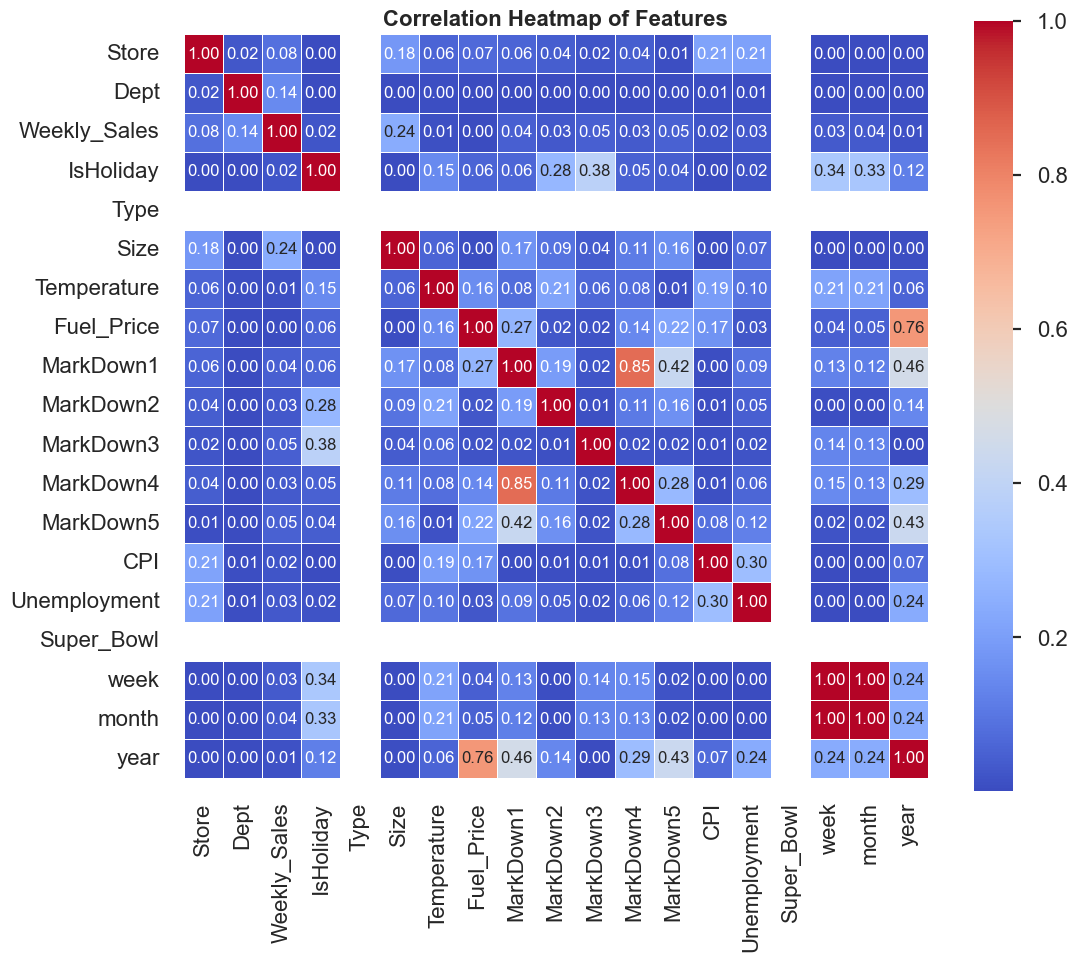

In [152]:
# Set figure size
plt.figure(figsize=(12, 10))

# Create a heatmap with enhancements
sns.heatmap(df_new.corr().abs(), 
            annot=True,  # Show correlation values
            fmt=".2f",   # Format to 2 decimal places
            cmap="coolwarm",  # Color scheme
            linewidths=0.5,  # Thin grid lines
            cbar=True,  # Show color bar
            square=True)  # Make cells square

# Add title for better context
plt.title("Correlation Heatmap of Features", fontsize=16, fontweight='bold')

# Show the plot
plt.show()

# Holiday analysis for weekly sales

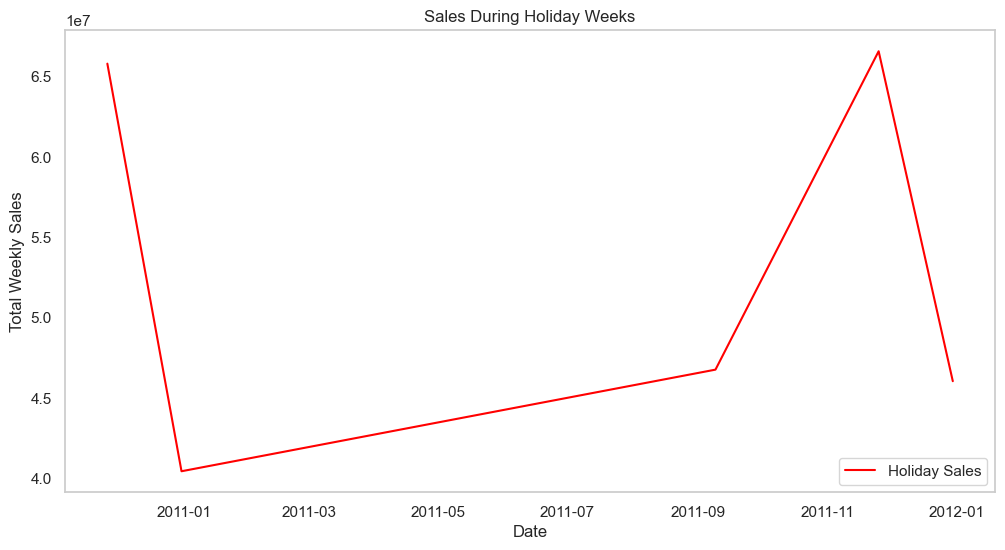

Average Sales During Holidays vs. Non-Holidays:
 IsHoliday
False    15789.665795
True     17943.792898
Name: Weekly_Sales, dtype: float64


'Answer:\n\nDo sales consistently spike on holidays?\nWhich holiday weeks have the highest sales?'

In [26]:
#  5. Holiday Sales Impact
"""Do sales spike during holidays? 
Which holidays have the biggest impact?"""

# Check sales on holidays
holiday_sales = full_df[full_df['IsHoliday'] == True].groupby('Date')['Weekly_Sales'].sum().reset_index()

# Plot holiday sales
plt.figure(figsize=(12, 6))
plt.plot(holiday_sales['Date'], holiday_sales['Weekly_Sales'], color='red', label='Holiday Sales')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Sales During Holiday Weeks')
plt.legend()
plt.grid()
plt.show()

# Check holiday impact
holiday_sales = full_df.groupby("IsHoliday")["Weekly_Sales"].mean()
print("Average Sales During Holidays vs. Non-Holidays:\n", holiday_sales)
"""Answer:

Do sales consistently spike on holidays?
Which holiday weeks have the highest sales?"""

In [19]:
train_df_holiday = train_df.loc[train_df['IsHoliday']==True]
train_df_holiday['Date'].unique()

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [20]:
train_df_not_holiday = train_df.loc[train_df['IsHoliday']==False]
train_df_not_holiday['Date'].nunique()

133

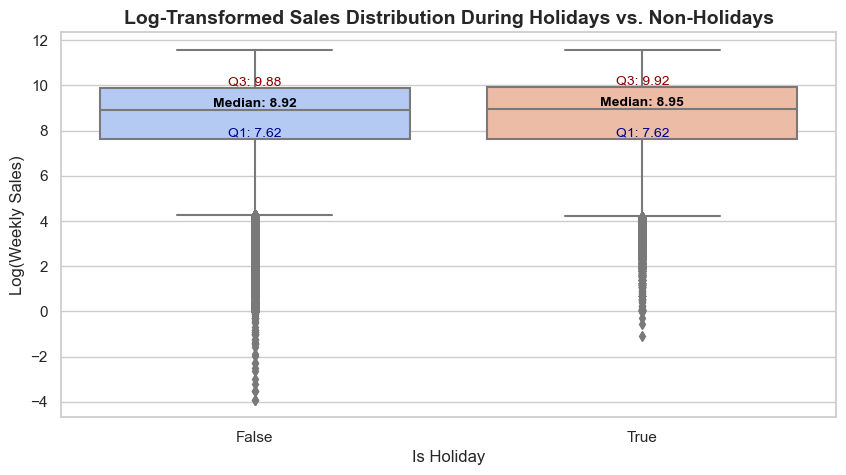

In [28]:
# Remove extreme outliers (top 1%)
q99 = train_df["Weekly_Sales"].quantile(0.99)
filtered_df = train_df[train_df["Weekly_Sales"] <= q99]

# Compute quartiles
stats = filtered_df.groupby("IsHoliday")["Weekly_Sales"].describe()[["25%", "50%", "75%"]]

# Create a figure
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

# Log transformation to reduce skewness
ax = sns.boxplot(x="IsHoliday", y=np.log1p(filtered_df["Weekly_Sales"]), palette="coolwarm" , data = filtered_df)

# Titles and labels
plt.title("Log-Transformed Sales Distribution During Holidays vs. Non-Holidays", fontsize=14, fontweight='bold')
plt.xlabel("Is Holiday", fontsize=12)
plt.ylabel("Log(Weekly Sales)", fontsize=12)

# Annotate medians & quartiles
for i, is_holiday in enumerate([False, True]):
    median = np.log1p(stats.loc[is_holiday, "50%"])
    q1 = np.log1p(stats.loc[is_holiday, "25%"])
    q3 = np.log1p(stats.loc[is_holiday, "75%"])

    # Add text annotation
    ax.text(i, median, f"Median: {median:.2f}", ha='center', va='bottom', fontsize=10, fontweight="bold", color="black")
    ax.text(i, q1, f"Q1: {q1:.2f}", ha='center', va='bottom', fontsize=10, color="darkblue")
    ax.text(i, q3, f"Q3: {q3:.2f}", ha='center', va='bottom', fontsize=10, color="darkred")

# Show the plot
plt.show()


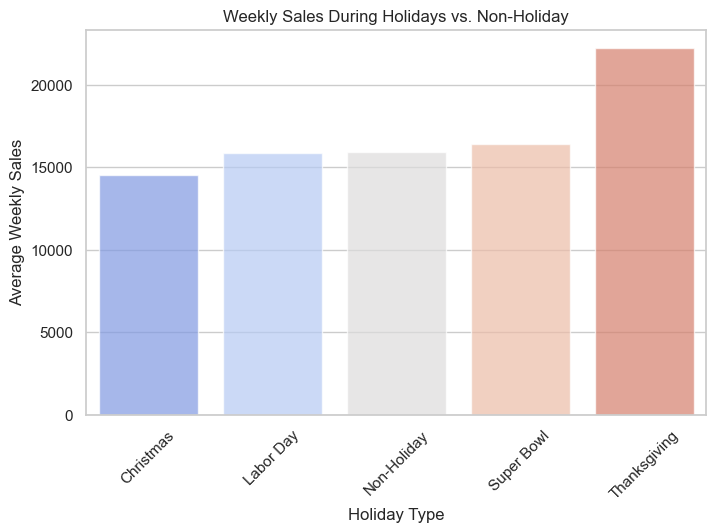

In [21]:
# Define holiday dates and labels
holiday_dates = {
    "Super Bowl": ["2010-02-12", "2011-02-11", "2012-02-10", "2013-02-08"],
    "Labor Day": ["2010-09-10", "2011-09-09", "2012-09-07", "2013-09-06"],
    "Thanksgiving": ["2010-11-26", "2011-11-25", "2012-11-23", "2013-11-29"],
    "Christmas": ["2010-12-31", "2011-12-30", "2012-12-28", "2013-12-27"]
}



# Assign holidays to a new column
def get_holiday(date):
    for holiday, dates in holiday_dates.items():
        if date.strftime("%Y-%m-%d") in dates:
            return holiday
    return "Non-Holiday"

train_df["Holiday_Type"] = train_df["Date"].apply(get_holiday)

# Group by Holiday_Type and calculate mean sales
holiday_sales = train_df.groupby("Holiday_Type")["Weekly_Sales"].mean().reset_index()

# Plot holiday vs. non-holiday sales
plt.figure(figsize=(8, 5))
sns.barplot(x="Holiday_Type", y="Weekly_Sales", data=holiday_sales, alpha=0.7, palette="coolwarm")
plt.title("Weekly Sales During Holidays vs. Non-Holiday")
plt.xlabel("Holiday Type")
plt.ylabel("Average Weekly Sales")
plt.xticks(rotation=45)
plt.show()

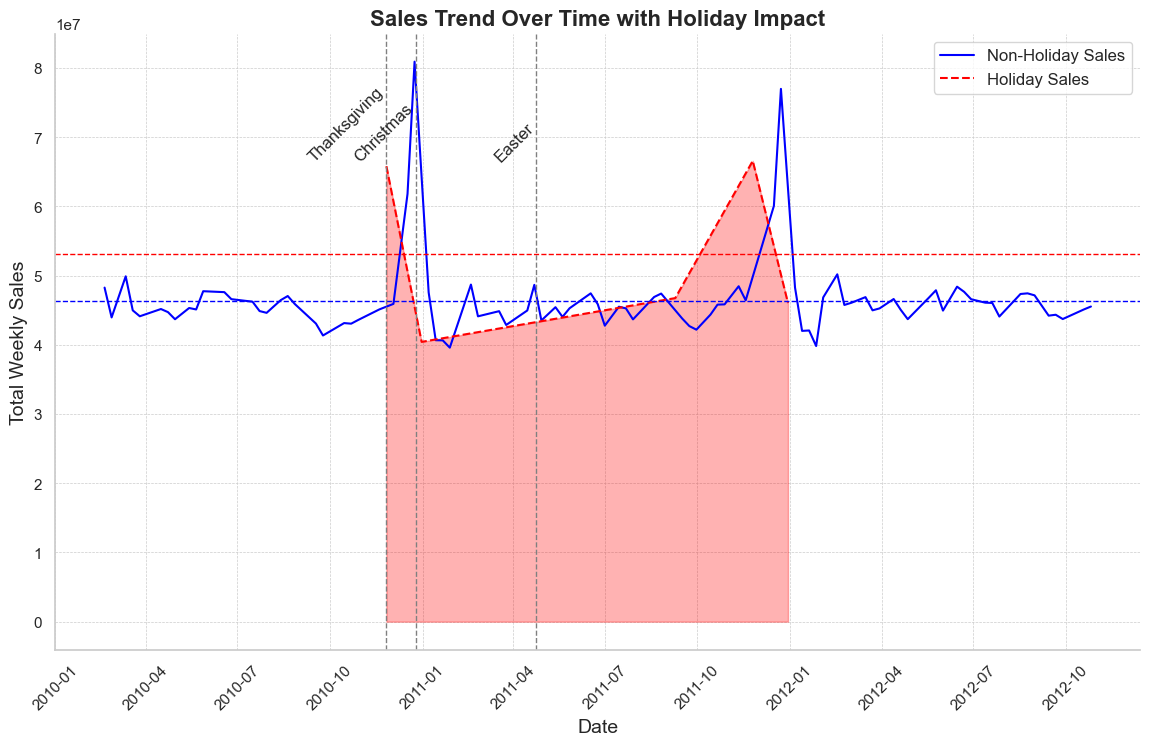

In [29]:
# Convert date to datetime format
full_df['Date'] = pd.to_datetime(full_df['Date'])

# Group sales by date and holiday status
sales_trend = full_df.groupby(['Date', 'IsHoliday'])['Weekly_Sales'].sum().reset_index()

# Split the sales data into holiday and non-holiday sales
holiday_sales = sales_trend[sales_trend['IsHoliday'] == True]
non_holiday_sales = sales_trend[sales_trend['IsHoliday'] == False]

# Calculate average sales for holidays and non-holidays
average_holiday_sales = holiday_sales['Weekly_Sales'].mean()
average_non_holiday_sales = non_holiday_sales['Weekly_Sales'].mean()

# Set Seaborn style
sns.set(style="whitegrid")

# Plot sales over time
plt.figure(figsize=(14, 8), dpi=100)

# Non-holiday sales
plt.plot(non_holiday_sales['Date'], non_holiday_sales['Weekly_Sales'], label='Non-Holiday Sales', color='blue')

# Holiday sales
plt.plot(holiday_sales['Date'], holiday_sales['Weekly_Sales'], label='Holiday Sales', color='red', linestyle='--')

# Highlight holiday weeks
plt.fill_between(holiday_sales['Date'], 0, holiday_sales['Weekly_Sales'], color='red', alpha=0.3)

# Title and labels
plt.title('Sales Trend Over Time with Holiday Impact', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Weekly Sales', fontsize=14)

# Grid and spines
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)


plt.legend(fontsize=12)

# Add horizontal lines for average sales
plt.axhline(average_holiday_sales, color='red', linestyle='--', linewidth=1, label='Average Holiday Sales')
plt.axhline(average_non_holiday_sales, color='blue', linestyle='--', linewidth=1, label='Average Non-Holiday Sales')

# Add annotations for major holidays
major_holidays = {
    'Christmas': '2010-12-25',
    'Thanksgiving': '2010-11-26',
    'Easter': '2011-04-24'
}
for holiday, date in major_holidays.items():
    plt.axvline(pd.to_datetime(date), color='grey', linestyle='--', linewidth=1)
    plt.text(pd.to_datetime(date), max(holiday_sales['Weekly_Sales']), holiday, rotation=45, fontsize=12, ha='right')

plt.show()


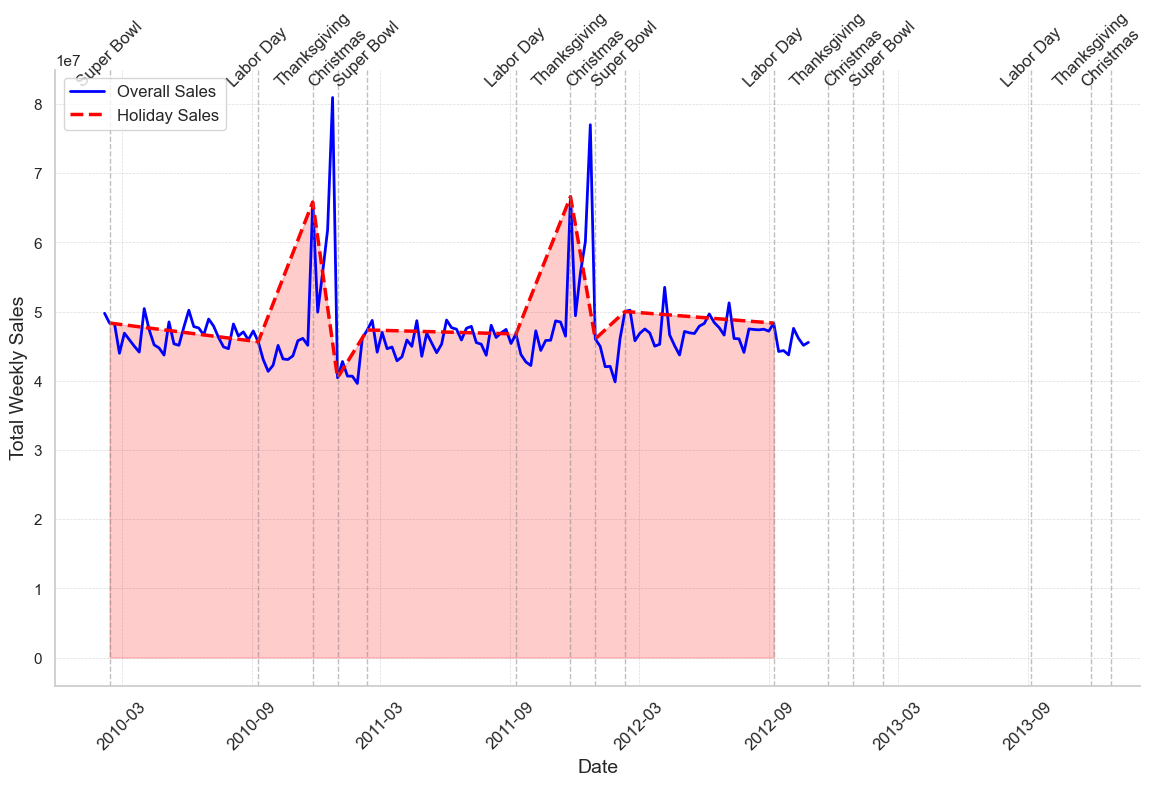

In [22]:

# Convert date to datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Define holiday dates
holiday_dates = {
    "Super Bowl": ["2010-02-12", "2011-02-11", "2012-02-10", "2013-02-08"],
    "Labor Day": ["2010-09-10", "2011-09-09", "2012-09-07", "2013-09-06"],
    "Thanksgiving": ["2010-11-26", "2011-11-25", "2012-11-23", "2013-11-29"],
    "Christmas": ["2010-12-31", "2011-12-30", "2012-12-28", "2013-12-27"]
}

# Flatten dictionary values into a list
all_holidays = [date for dates in holiday_dates.values() for date in dates]

# Filter holiday sales
train_df['IsHoliday'] = train_df['Date'].astype(str).isin(all_holidays)

# Group sales by date
sales_trend = train_df.groupby('Date')['Weekly_Sales'].sum().reset_index()
holiday_sales_trend = train_df[train_df['IsHoliday']].groupby('Date')['Weekly_Sales'].sum().reset_index()

# Plot sales over time
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8), dpi=100)
plt.plot(sales_trend['Date'], sales_trend['Weekly_Sales'], label='Overall Sales', color='blue', linewidth=2)
plt.plot(holiday_sales_trend['Date'], holiday_sales_trend['Weekly_Sales'], color='red', label='Holiday Sales', linestyle='--', linewidth=2.5)
plt.fill_between(holiday_sales_trend['Date'], 0, holiday_sales_trend['Weekly_Sales'], color='red', alpha=0.2)

# Title and labels
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Weekly Sales', fontsize=14)

# Grid and spines
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Format x-axis (reduce clutter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, fontsize=12)

# Add vertical lines and labels for major holidays
for holiday, dates in holiday_dates.items():
    for date in dates:
        holiday_date = pd.to_datetime(date)
        plt.axvline(holiday_date, color='grey', linestyle='--', linewidth=1, alpha=0.5)
        plt.text(holiday_date, max(sales_trend['Weekly_Sales']) * 1.02, holiday, rotation=45, fontsize=12, ha='center')

# Show legend
plt.legend(fontsize=12)

# Show plot
plt.show()


In [30]:
full_df['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

(-1.1073279576909092,
 1.1003489503662338,
 -1.1184477161638255,
 1.1051886826392097)

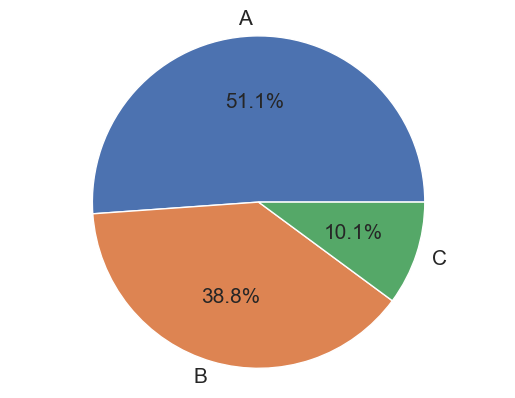

In [31]:
full_df_counts = full_df['Type'].value_counts()  # Count occurrences of each type
plt.pie(full_df_counts, labels=full_df_counts.index, autopct='%1.1f%%', textprops={'fontsize': 15})
plt.axis('equal')

In [32]:
full_df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15789.665795
True     17943.792898
Name: Weekly_Sales, dtype: float64

In [85]:
# Super bowl dates 
full_df.loc[(full_df['Date'] == '2010-02-12')|(full_df['Date'] == '2011-02-11')|(full_df['Date'] == '2012-02-10'),'Super_Bowl'] = True
full_df.loc[(full_df['Date'] != '2010-02-12')&(full_df['Date'] != '2011-02-11')&(full_df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [34]:
# Labor day dates 
full_df.loc[(full_df['Date'] == '2010-09-10')|(full_df['Date'] == '2011-09-09')|(full_df['Date'] == '2012-09-07'),'Labor_Day'] = True
full_df.loc[(full_df['Date'] != '2010-09-10')&(full_df['Date'] != '2011-09-09')&(full_df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [35]:
# Thanksgiving dates 
full_df.loc[(full_df['Date'] == '2010-11-26')|(full_df['Date'] == '2011-11-25'),'Thanksgiving'] = True
full_df.loc[(full_df['Date'] != '2010-11-26')&(full_df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [36]:
#Christmas dates 
full_df.loc[(full_df['Date'] == '2010-12-31')|(full_df['Date'] == '2011-12-30'),'Christmas'] = True
full_df.loc[(full_df['Date'] != '2010-12-31')&(full_df['Date'] != '2011-12-30'),'Christmas'] = False

<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

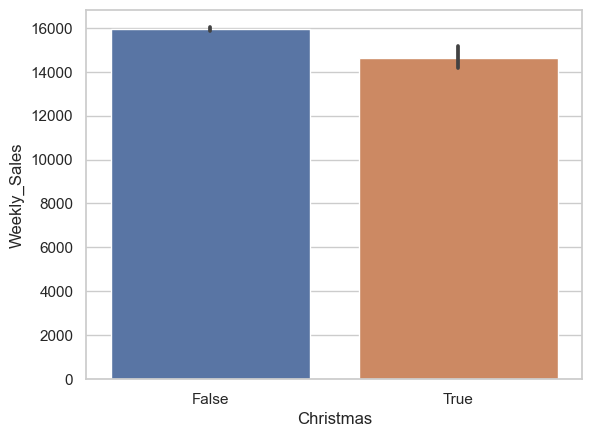

In [37]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=full_df) # Christmas holiday vs not-Christmas

<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

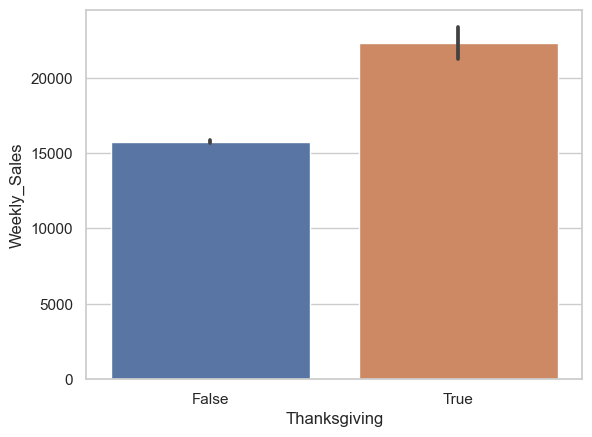

In [38]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=full_df) # Thanksgiving holiday vs not-thanksgiving

<AxesSubplot:xlabel='Super_Bowl', ylabel='Weekly_Sales'>

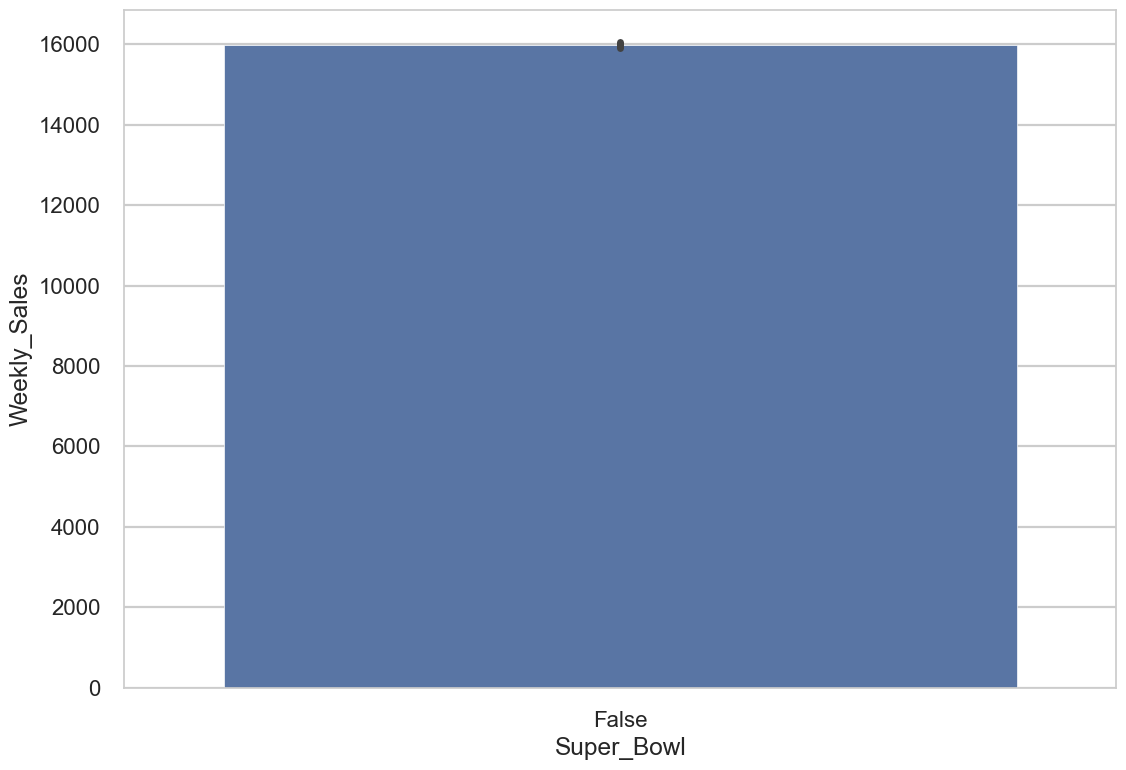

In [96]:
 sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=test_df) # Super bowl holiday vs not-super bowl


<AxesSubplot:xlabel='Labor_Day', ylabel='Weekly_Sales'>

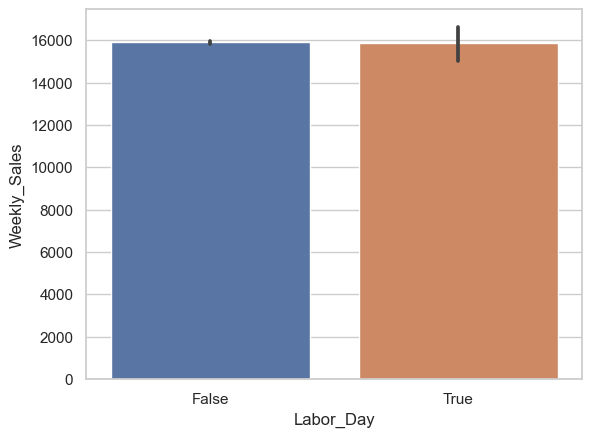

In [40]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=full_df) # Labor day holiday vs not-labor day


In [41]:
full_df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas 

Christmas  Type
False      A       19990.314259
           B       12264.646761
           C        9454.677681
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [42]:
full_df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       19955.728580
           B       12250.422449
           C        9423.406180
True       A       19892.605342
           B       12055.552860
           C        9587.368475
Name: Weekly_Sales, dtype: float64

In [43]:
full_df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       19794.641847
              B       12108.320279
              C        9419.359766
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [44]:
full_df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       19955.062434
            B       12248.403417
            C        9425.101311
Name: Weekly_Sales, dtype: float64

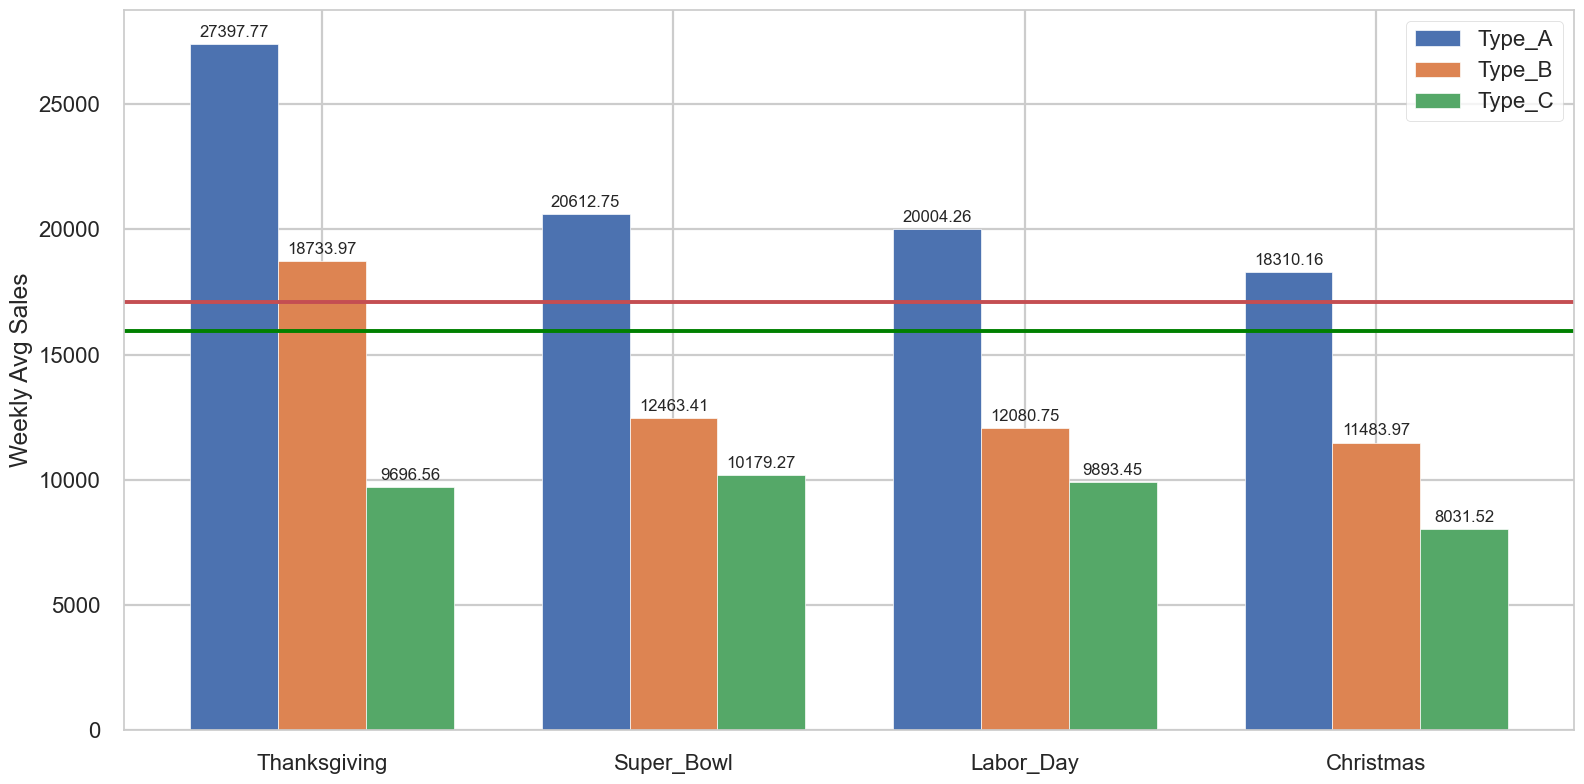

In [45]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

'Size of the type of stores are consistent with sales,\nHigher size stores has higher sales. \nAnd, Walmart classify stores according to their sizes \naccording to graph. After the smallest size value of Type A, Type B \nbegins. After the smallest size value of Type B, Type C begins.'

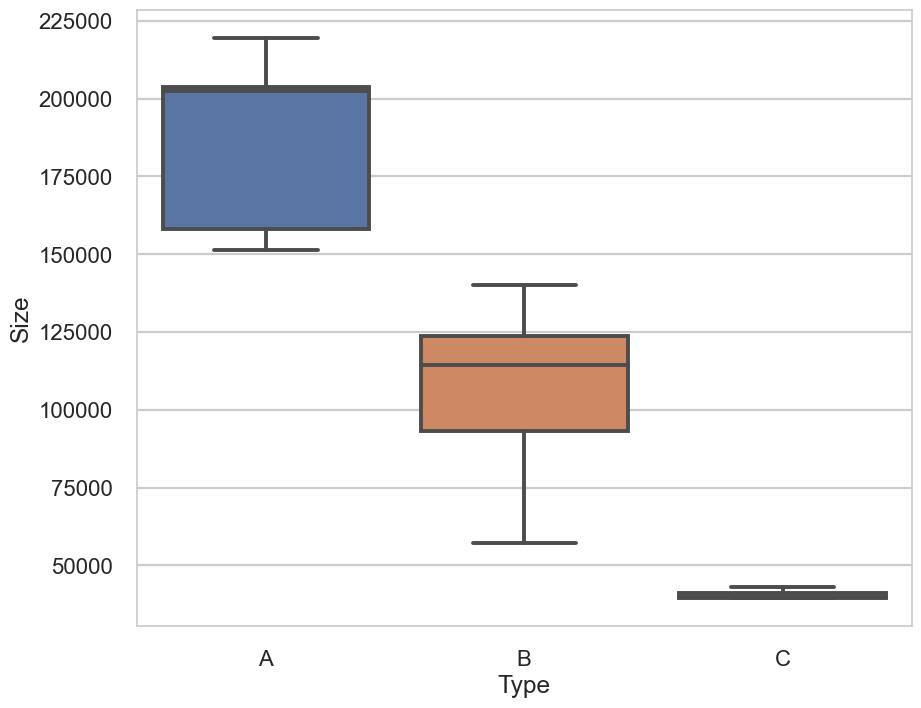

In [46]:
#To See the Size - Type Relation
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=full_df, showfliers=False)

'''Size of the type of stores are consistent with sales,
Higher size stores has higher sales. 
And, Walmart classify stores according to their sizes 
according to graph. After the smallest size value of Type A, Type B 
begins. After the smallest size value of Type B, Type C begins.'''

 # Date deeper analysis

In [98]:
full_df["Date"] = pd.to_datetime(full_df["Date"]) # convert to datetime
full_df['week'] =full_df['Date'].dt.week
full_df['month'] =full_df['Date'].dt.month 
full_df['year'] =full_df['Date'].dt.year

In [101]:
full_df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14547.537763
2     15828.599970
3     15466.238053
4     15337.374369
5     15722.292383
6     16001.300274
7     15392.933629
8     16049.545476
9     14817.472882
10    15157.050657
11    18447.795817
12    19842.379834
Name: Weekly_Sales, dtype: float64

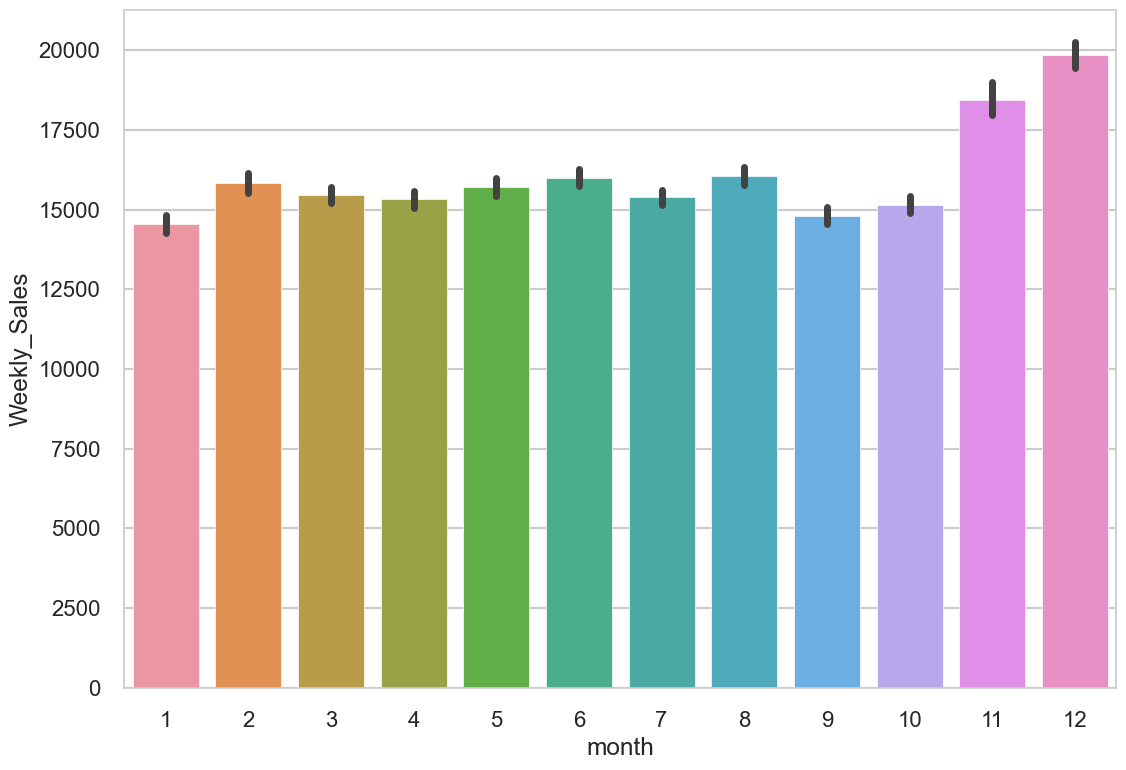

In [106]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=full_df)

<AxesSubplot:xlabel='month'>

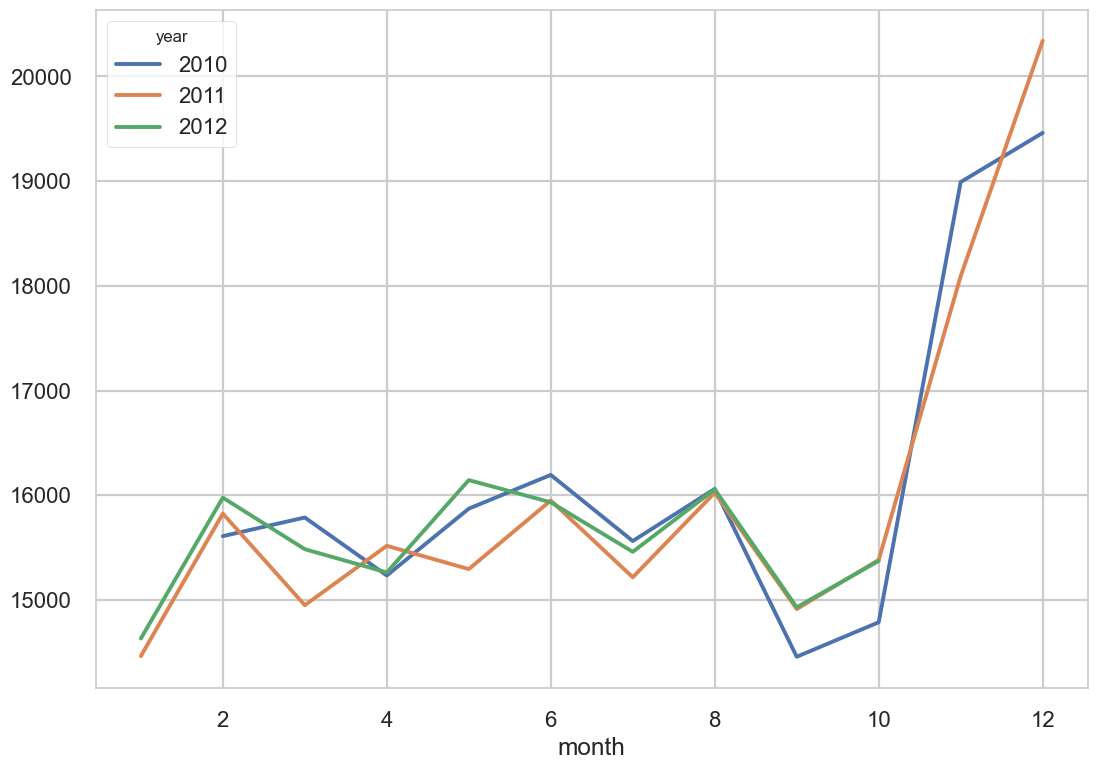

In [107]:
monthly_sales = pd.pivot_table(full_df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

In [103]:
full_df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16277.733490
2011    15947.570402
2012    15492.869341
Name: Weekly_Sales, dtype: float64

In [110]:
full_df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
10    17005.328688
7     16517.946636
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='week'>

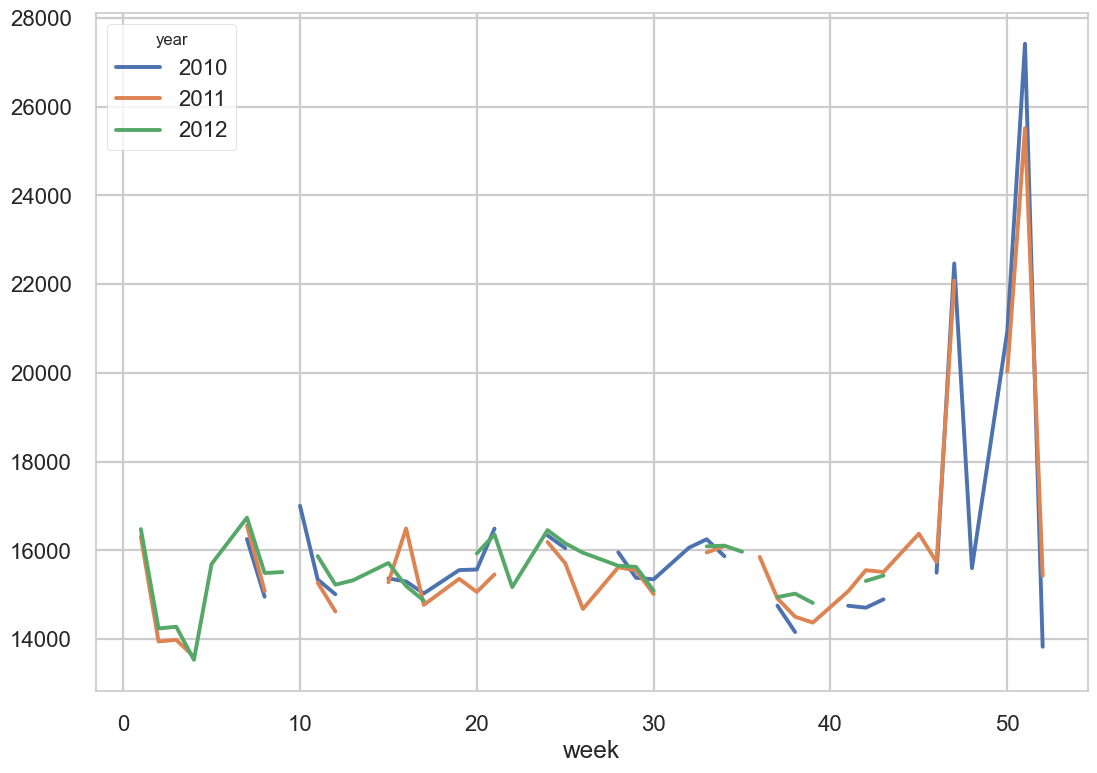

In [112]:
weekly_sales = pd.pivot_table(full_df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

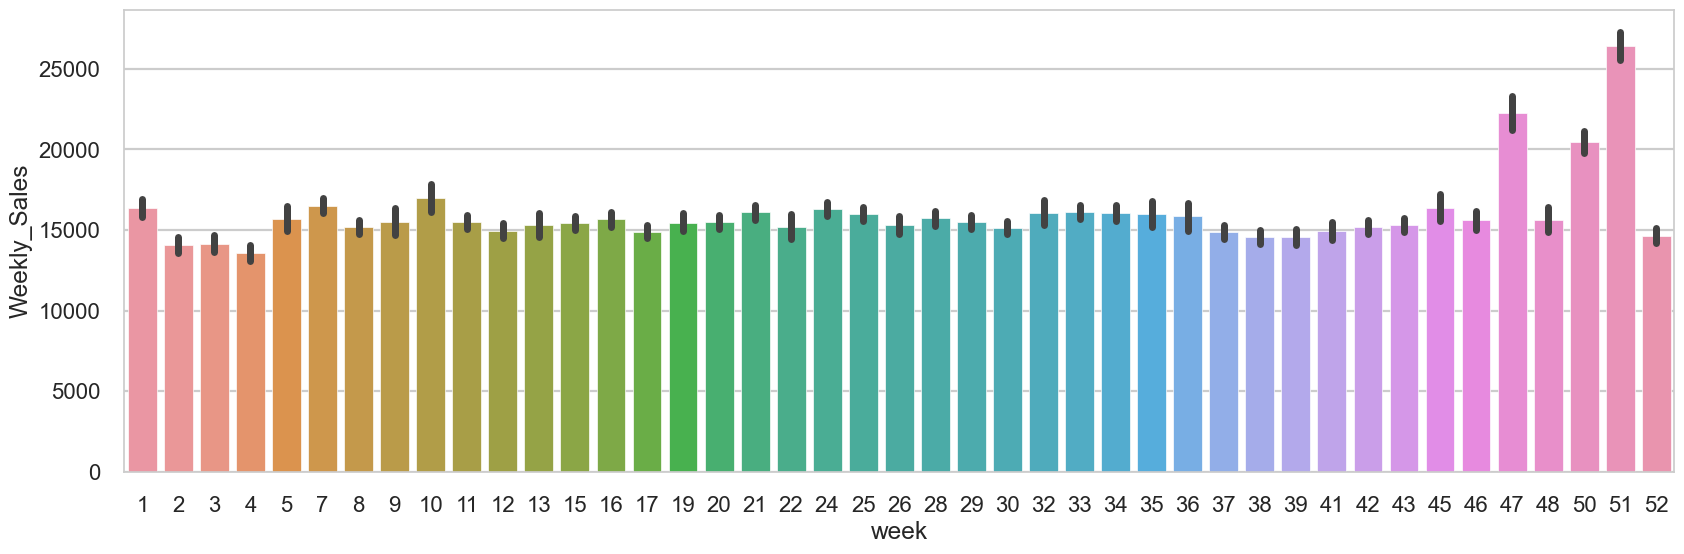

In [114]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=full_df)

Cleaning Process
   - The data has no too much missing values. All columns was checked.
   - choose rows which has higher than 0 weekly sales. Minus values are 0.3%        of data. So, dropped them.
   - Null values in markdowns changed to zero. Because, they were written as        null if there were no markdown on this department.

Explorations & Findings
   - There are 45 stores and 81 department in data. Departments are not same in 
     all stores.
   - Although department 72 has higher weekly sales values, on average  
     department 92 is the best. It shows us, some departments has higher values 
     as seasonal like Thanksgiving. It is consistant when we look at the top 5      sales in data, all of them belongs to 72th department at Thanksgiving 
     holiday time.
   - Although stores 10 and 35 have higher weekly sales values sometimes, in        general average store 20 and store 4 are on the first and second rank. It 
     means that some areas has higher seasonal sales.
   - Stores has 3 types as A, B and C according to their sizes. Almost half of 
     the stores are bigger than 150000 and categorized as A. According to type, 
     sales of the stores are changing.
   - As expected, holiday average sales are higher than normal dates.
   - Christmas holiday introduces as the last days of the year. But people    
     generally shop at 51th week. So, when we look at the total sales of  
     holidays, Thankgiving has higher sales between them which was assigned by 
     Walmart.
   - Year 2010 has higher sales than 2011 and 2012. But, November and December 
     sales are not in the data for 2012. Even without highest sale months, 2012      is not significantly less than 2010, so after adding last two months, it        can be first.
   - It is obviously seen that week 51 and 47 have higher values and 50-48 
     weeks follow them. Interestingly, 5th top sales belongs to 22th week of 
     the year. This results show that Christmas, Thankgiving and Black Friday 
     are very important than other weeks for sales and 5th important time is   
     22th week of the year and it is end of the May, when schools are closed. 
     Most probably, people are preparing for holiday at the end of the May. 
   - January sales are significantly less than other months. This is the result 
     of November and December high sales. After two high sales month, people 
     prefer to pay less on January.
   - CPI, temperature, unemployment rate and fuel price have no pattern on 
     weekly sales.

# Encode Categorical column

In [140]:
df_encoded_1 = full_df.copy()

In [141]:
df_encoded_1.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Size_Category,Temperature,Fuel_Price,...,MarkDown5,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-19,41595.55,False,A,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,False,False,False,False,7,2,2010
1,1,2,2010-02-19,47928.89,False,A,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,False,False,False,False,7,2,2010
2,1,3,2010-02-19,11523.47,False,A,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,False,False,False,False,7,2,2010
3,1,4,2010-02-19,36826.95,False,A,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,False,False,False,False,7,2,2010
4,1,5,2010-02-19,26468.27,False,A,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,False,False,False,False,7,2,2010


In [142]:
type_group = {'A':1, 'B': 2, 'C': 3}  
df_encoded_1['Type'] = df_encoded_1['Type'].replace(type_group)
df_encoded_1

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Size_Category,Temperature,Fuel_Price,...,MarkDown5,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-19,41595.55,False,1,151315,150K-200K,39.93,2.514,...,0.00,211.289143,8.106,False,False,False,False,7,2,2010
1,1,2,2010-02-19,47928.89,False,1,151315,150K-200K,39.93,2.514,...,0.00,211.289143,8.106,False,False,False,False,7,2,2010
2,1,3,2010-02-19,11523.47,False,1,151315,150K-200K,39.93,2.514,...,0.00,211.289143,8.106,False,False,False,False,7,2,2010
3,1,4,2010-02-19,36826.95,False,1,151315,150K-200K,39.93,2.514,...,0.00,211.289143,8.106,False,False,False,False,7,2,2010
4,1,5,2010-02-19,26468.27,False,1,151315,150K-200K,39.93,2.514,...,0.00,211.289143,8.106,False,False,False,False,7,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282105,45,93,2012-10-26,2487.80,False,2,118221,100K-150K,58.85,3.882,...,858.33,192.308899,8.667,False,False,False,False,43,10,2012
282106,45,94,2012-10-26,5203.31,False,2,118221,100K-150K,58.85,3.882,...,858.33,192.308899,8.667,False,False,False,False,43,10,2012
282107,45,95,2012-10-26,56017.47,False,2,118221,100K-150K,58.85,3.882,...,858.33,192.308899,8.667,False,False,False,False,43,10,2012
282108,45,97,2012-10-26,6817.48,False,2,118221,100K-150K,58.85,3.882,...,858.33,192.308899,8.667,False,False,False,False,43,10,2012


In [144]:
df_encoded_1['Super_Bowl'] = df_encoded_1['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [145]:
df_encoded_1['Thanksgiving'] = df_encoded_1['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [146]:
df_encoded_1['Labor_Day'] = df_encoded_1['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

In [147]:
df_encoded_1['Christmas'] = df_encoded_1['Christmas'].astype(bool).astype(int) # changing T,F to 0-1

In [148]:
df_encoded_1['IsHoliday'] = df_encoded_1['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [149]:
df_encoded_1.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Size_Category,Temperature,Fuel_Price,...,MarkDown5,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-19,41595.55,0,1,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,0,0,0,0,7,2,2010
1,1,2,2010-02-19,47928.89,0,1,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,0,0,0,0,7,2,2010
2,1,3,2010-02-19,11523.47,0,1,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,0,0,0,0,7,2,2010
3,1,4,2010-02-19,36826.95,0,1,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,0,0,0,0,7,2,2010
4,1,5,2010-02-19,26468.27,0,1,151315,150K-200K,39.93,2.514,...,0.0,211.289143,8.106,0,0,0,0,7,2,2010


# Prepare data for train

In [150]:
df_new = df_encoded.copy()

In [165]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas' ,'Temperature','MarkDown4','MarkDown5','CPI','Unemployment','Size_Category']

df_new.drop(drop_col, axis=1, inplace=True)

- Temperature, unemployment, CPI have no significant effect on weekly   sales, so drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem

In [166]:
df_new.to_csv('train_filtered.csv', index=False)

# Train-Test Split

In [167]:
# Separate features (X) and target variable (y)
X = df_new.drop(columns=['Weekly_Sales']) 
y = df_new['Weekly_Sales']

# Split data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Set: {X_train.shape}, Test Set: {X_test.shape}")

Train Set: (225688, 13), Test Set: (56422, 13)


In [168]:
X_new = X.drop(columns=['Date'])

In [169]:
X_train = X_train.drop(['Date'], axis=1) 
X_test = X_test.drop(['Date'], axis=1) 

# Feature importance (RandomForest Regressor)

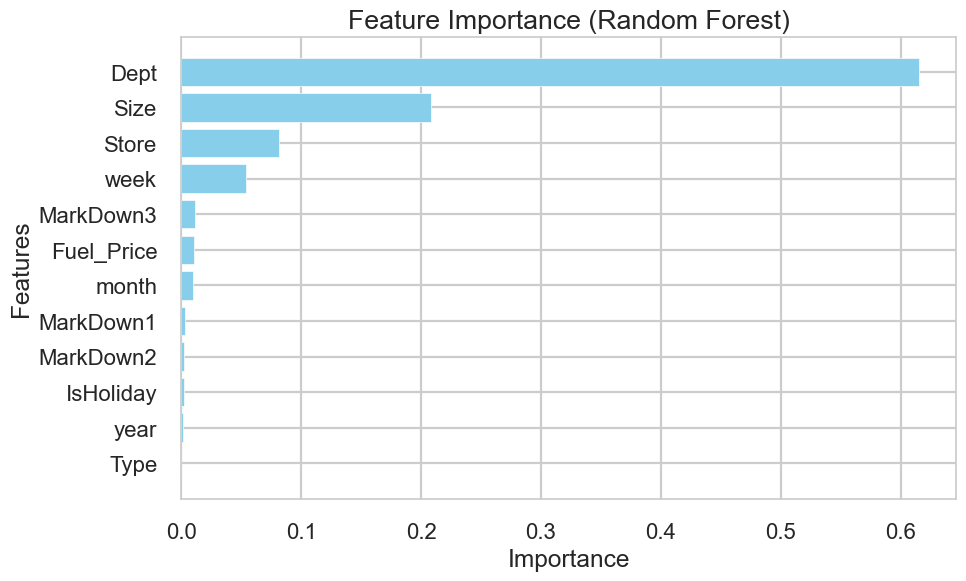

In [171]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_new, y)

# Get feature importances
importances = model.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({'Feature': X_new.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()  # Flip to show the most important feature on top
plt.show()